EDA --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)

### Objective

- Compare RF, XGB and LGBM default setting performance
- Practice model explaination

In [1]:
# setup environment
input_path = './data/'
output_path = './output02/'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [2]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset

predict_features = df_train_raw.columns.to_list()[-7:]

# prepare stratify Series to split train / val datasets
stratify = df_train_raw[predict_features[0]]
for feature in predict_features[1:]:
    stratify = 10 * stratify + df_train_raw[feature]
stratify = stratify.apply(lambda x: 10001 if x in [10010, 1010000] else x)

train_raw, val_raw = \
    train_test_split(df_train_raw, test_size=0.25, 
                     random_state=42, stratify=stratify)

train_raw.reset_index(drop=True, inplace=True)
val_raw.reset_index(drop=True, inplace=True)

X_train_raw = train_raw.drop(columns=predict_features+['id'])
Y_train = train_raw[predict_features]
X_val_raw = val_raw.drop(columns=predict_features+['id'])
Y_val = val_raw[predict_features]
X_test_raw = df_test_raw.drop(columns=['id'])

# X transformer function
def X_transformer(X_raw):
    X = X_raw.copy()
    X['X_Center'] = (X['X_Maximum'] + X['X_Minimum'])/2
    X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
    X['Y_Center'] = (X['Y_Maximum'] + X['Y_Minimum'])/2
    X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']
    X['Aspect_Ratio'] = X['Y_Perimeter'] / X['X_Perimeter']
    X['Mean_Luminosity'] = X['Sum_of_Luminosity'] / (10**X['LogOfAreas'])
    X['Delta_Luminosity'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
    X['Log_Pixel_Resolution'] = ((10**X['LogOfAreas']) / X['Pixels_Areas']).apply(np.log10)
    X.drop(columns=['Pixels_Areas'], inplace=True)
    return X

X_train = X_transformer(X_train_raw)
X_val = X_transformer(X_val_raw)
X_test = X_transformer(X_test_raw)

In [3]:
# define and fit models
models = {'RF': dict(), 'XGB': dict(), 'LGBM': dict()}
model_types = ['RF', 'XGB', 'LGBM']
for feature in predict_features:
    models['RF'][feature] = RandomForestClassifier(n_jobs=-1, random_state=314)
    models['XGB'][feature] = XGBClassifier(n_jobs=-1, random_state=314)
    models['LGBM'][feature] = LGBMClassifier(n_jobs=-1, random_state=314, verbose=-1)
for model_type in model_types:
    for feature in predict_features:
        models[model_type][feature].fit(X_train, Y_train[feature])
        pass

# pickle.dump(models, open(output_path + 'models.pickle', 'wb'))
# models = pickle.load(open(output_path + 'models.pickle', 'rb'))

In [4]:
# score summary
summary_auc = {'Model': []}
for feature in predict_features:
    summary_auc[feature] = []
for model_type in model_types:
    summary_auc['Model'].append(model_type)
    for feature in predict_features:
        model = models[model_type][feature]
        y_score = model.predict_proba(X_val)[:, 1]
        auc_score = metrics.roc_auc_score(Y_val[feature], y_score)
        summary_auc[feature].append(auc_score)

In [5]:
df_auc = pd.DataFrame(summary_auc)
df_auc['Average_score'] = df_auc.drop(columns=['Model']).mean(axis=1)
print('ROC_AUC score:')
df_auc

ROC_AUC score:


,Model,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,Average_score
0,RF,0.835192,0.948712,0.985579,0.993757,0.831323,0.789265,0.691805,0.867948
1,XGB,0.838727,0.958142,0.985910,0.993852,0.862347,0.789175,0.685630,0.873397
2,LGBM,0.850801,0.963620,0.987030,0.993175,0.849687,0.806009,0.703702,0.879146


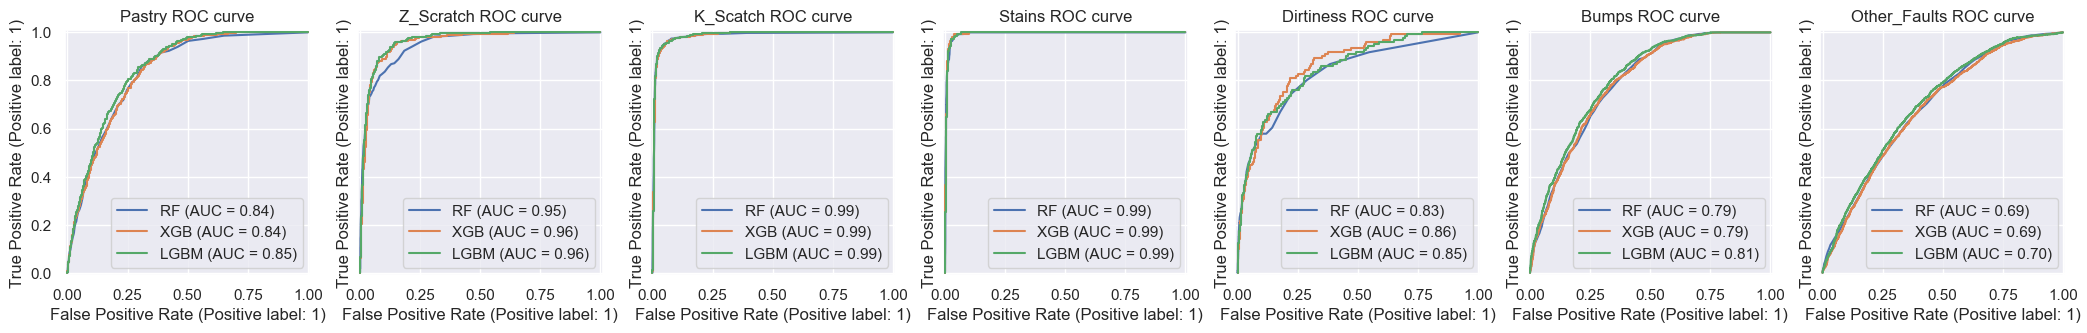

In [6]:
# plot ROC curve
fig, axs = plt.subplots(1, len(predict_features), sharex=True, sharey=True, 
                        figsize=(21, 4))
for model_type in model_types:
    for i in range(len(predict_features)):
        feature = predict_features[i]
        ax = axs[i]
        if model_type == 'RF':
            ax.set_title(feature + ' ROC curve')
        model = models[model_type][feature]
        metrics.RocCurveDisplay.from_estimator(model, X_val, Y_val[feature],
                                               name=model_type, ax=ax)
fig.tight_layout()
fig.show()

### AUC score result

Based on AUC score, all defect types fall into **3 classes**:  
1. **High** AUC score, including `Z_Scratch`, `K_Scatch` and `Stains`
2. **Mid** AUC score, including `Pastry` and `Dirtiness`
3. **Low** AUC score, including `Bumps` and `Other_Faults`
- This observation is quite consistent with our [EDA summary](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)

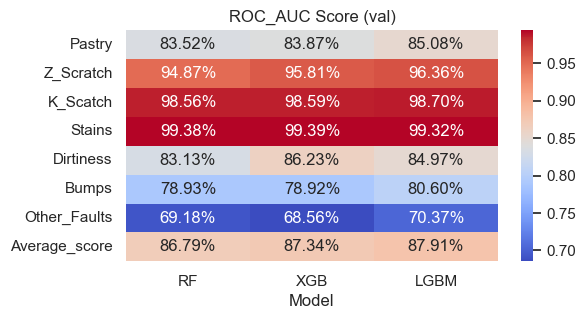

In [7]:
plt.figure(figsize=(6, 3))
sns.heatmap(df_auc.set_index('Model').transpose(), annot=True, cmap='coolwarm', fmt=".2%")
plt.title('ROC_AUC Score (val)')
plt.show()

### Model comparison

**(worst) RF < XGB ≈ LGBM (best)**  
- RF shows clear weakness in predicting `Z_Scratch` and `Dirtiness`
- XGB is strong in predicting `Dirtiness`
- LGBM performance is more balanced

**NOTE**: this ranking is based on model default setting, without hyperparameter tuning.

### Model explaination

Below study is based on LGBM models.  
Firstly let's compare **model feature improtance** *vs.* **permutation importance**. 

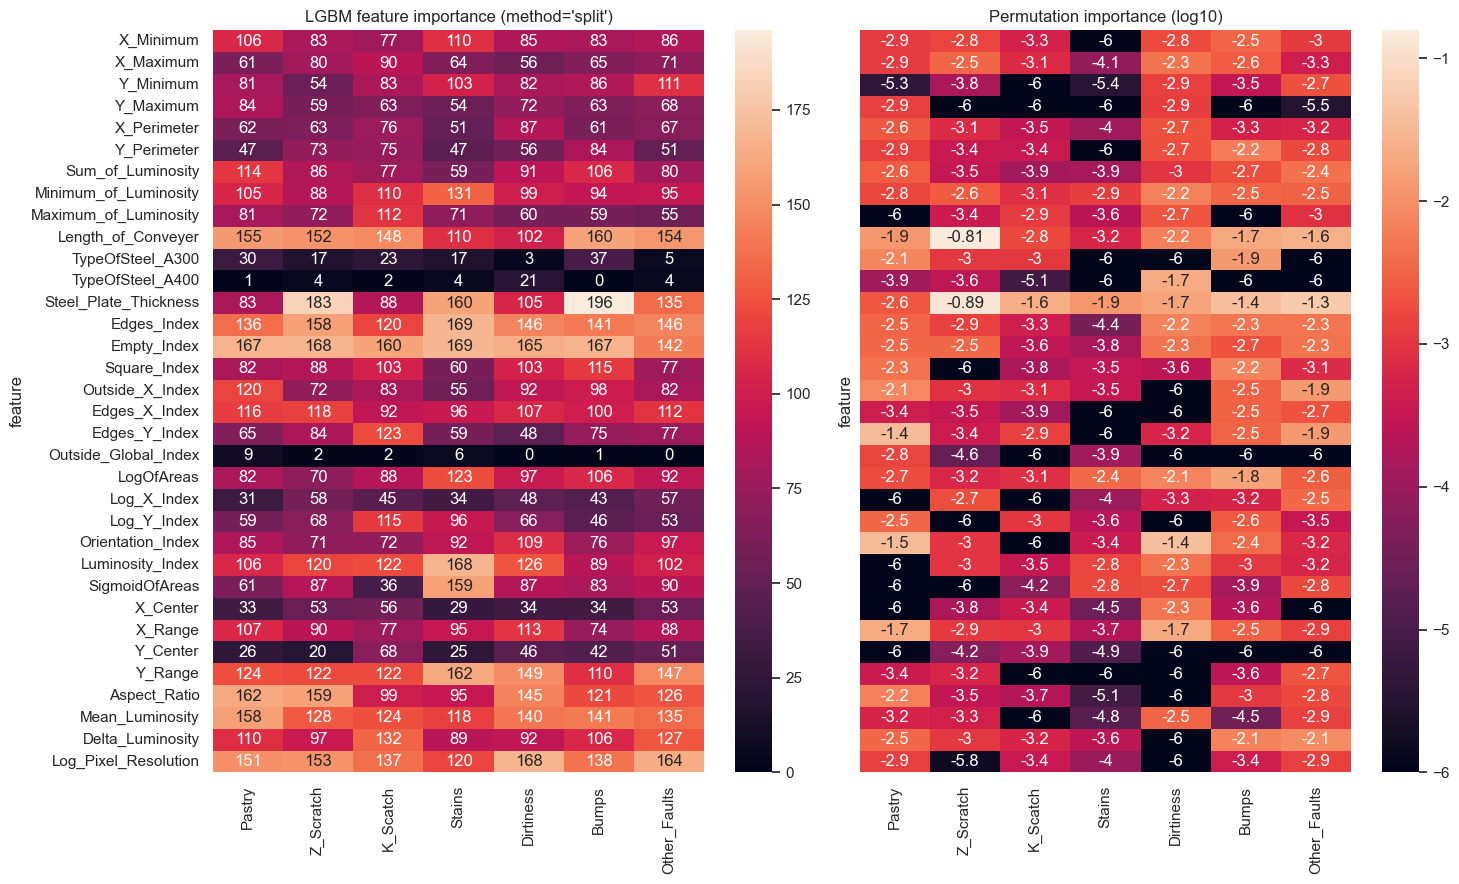

In [56]:
model_importance = {'feature': X_train.columns.to_list()}
permu_importance = {'feature': X_train.columns.to_list()}
for feature in predict_features:
    model = models['LGBM'][feature]
    model_importance[feature] = model.feature_importances_
    permu_importance[feature] = permutation_importance(model, X_val, Y_val[feature], scoring='roc_auc', n_repeats=50,
                                                       n_jobs=-1, random_state=0)['importances_mean']

model_importance = pd.DataFrame(model_importance).set_index('feature')
permu_importance = pd.DataFrame(permu_importance).set_index('feature')

df_temp = permu_importance.copy()
for index in df_temp.index:
    for col in df_temp.columns:
        df_temp.loc[index, col] = max(df_temp.loc[index, col], 1e-6)

fig, axs = plt.subplots(1, 2, figsize=(15, 9), sharey=True)
sns.heatmap(model_importance, annot=True, fmt='d', ax=axs[0])
axs[0].set_title("LGBM feature importance (method='split')")
sns.heatmap(np.log10(df_temp), annot=True, ax=axs[1])
axs[1].set_title('Permutation importance (log10)')
fig.tight_layout()

- There is some inconsistency between these 2 methods to calculate feature importance.
    - Each method has its own advantages and drawbacks.
    - `TypeOfSteel` shows low importance (total number making splits) in LGBM trees, but quite high permutation importance for some defects.
        - Permutation importance is more accurate for this feature as our [EDA](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3) does show significant prediciton power of this feature on these defects.
    - `Log_Pixel_Resolution` shows high importance in making tree splits, but is underestimated in permutation importance.
        - I think split method is more accurate for this feature.
        - Due to high data imbalance on this feature, permutation method is difficult to catch its effect.

Now let's explore **SHAP value**.

Pastry


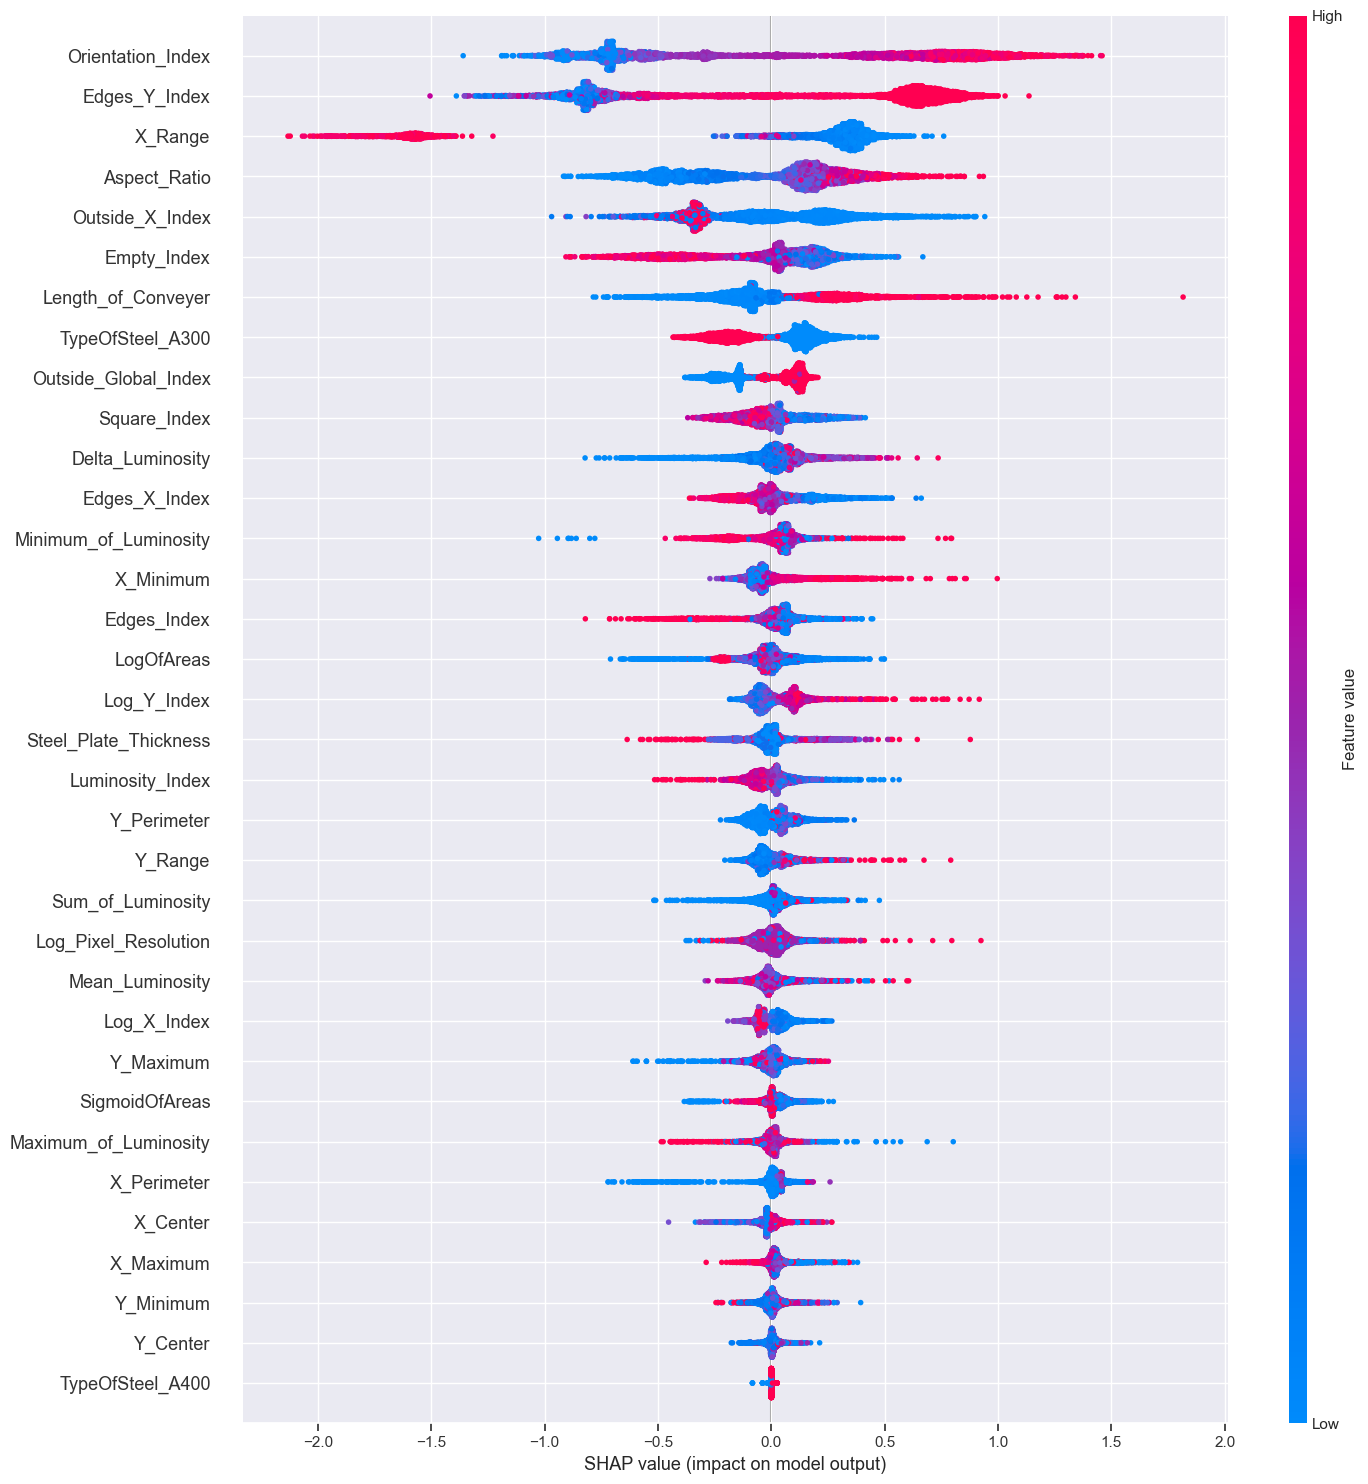

Z_Scratch


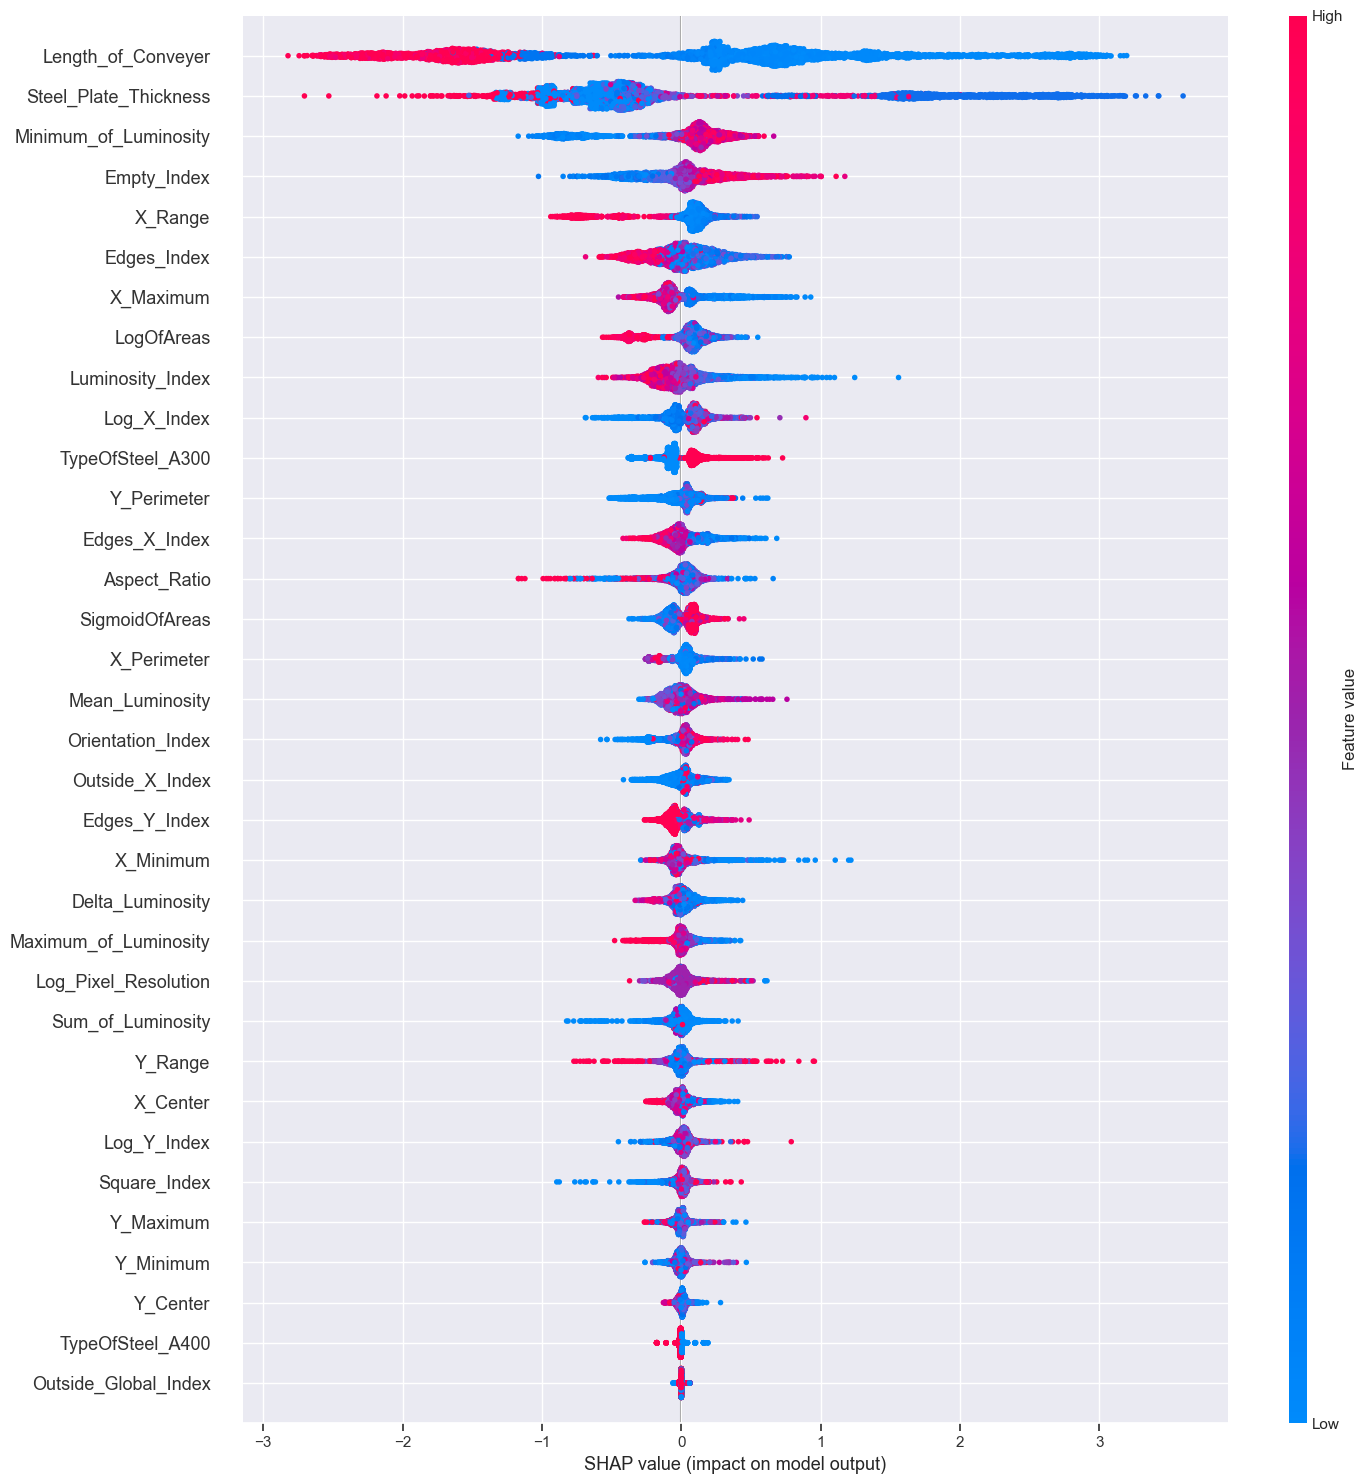

K_Scatch


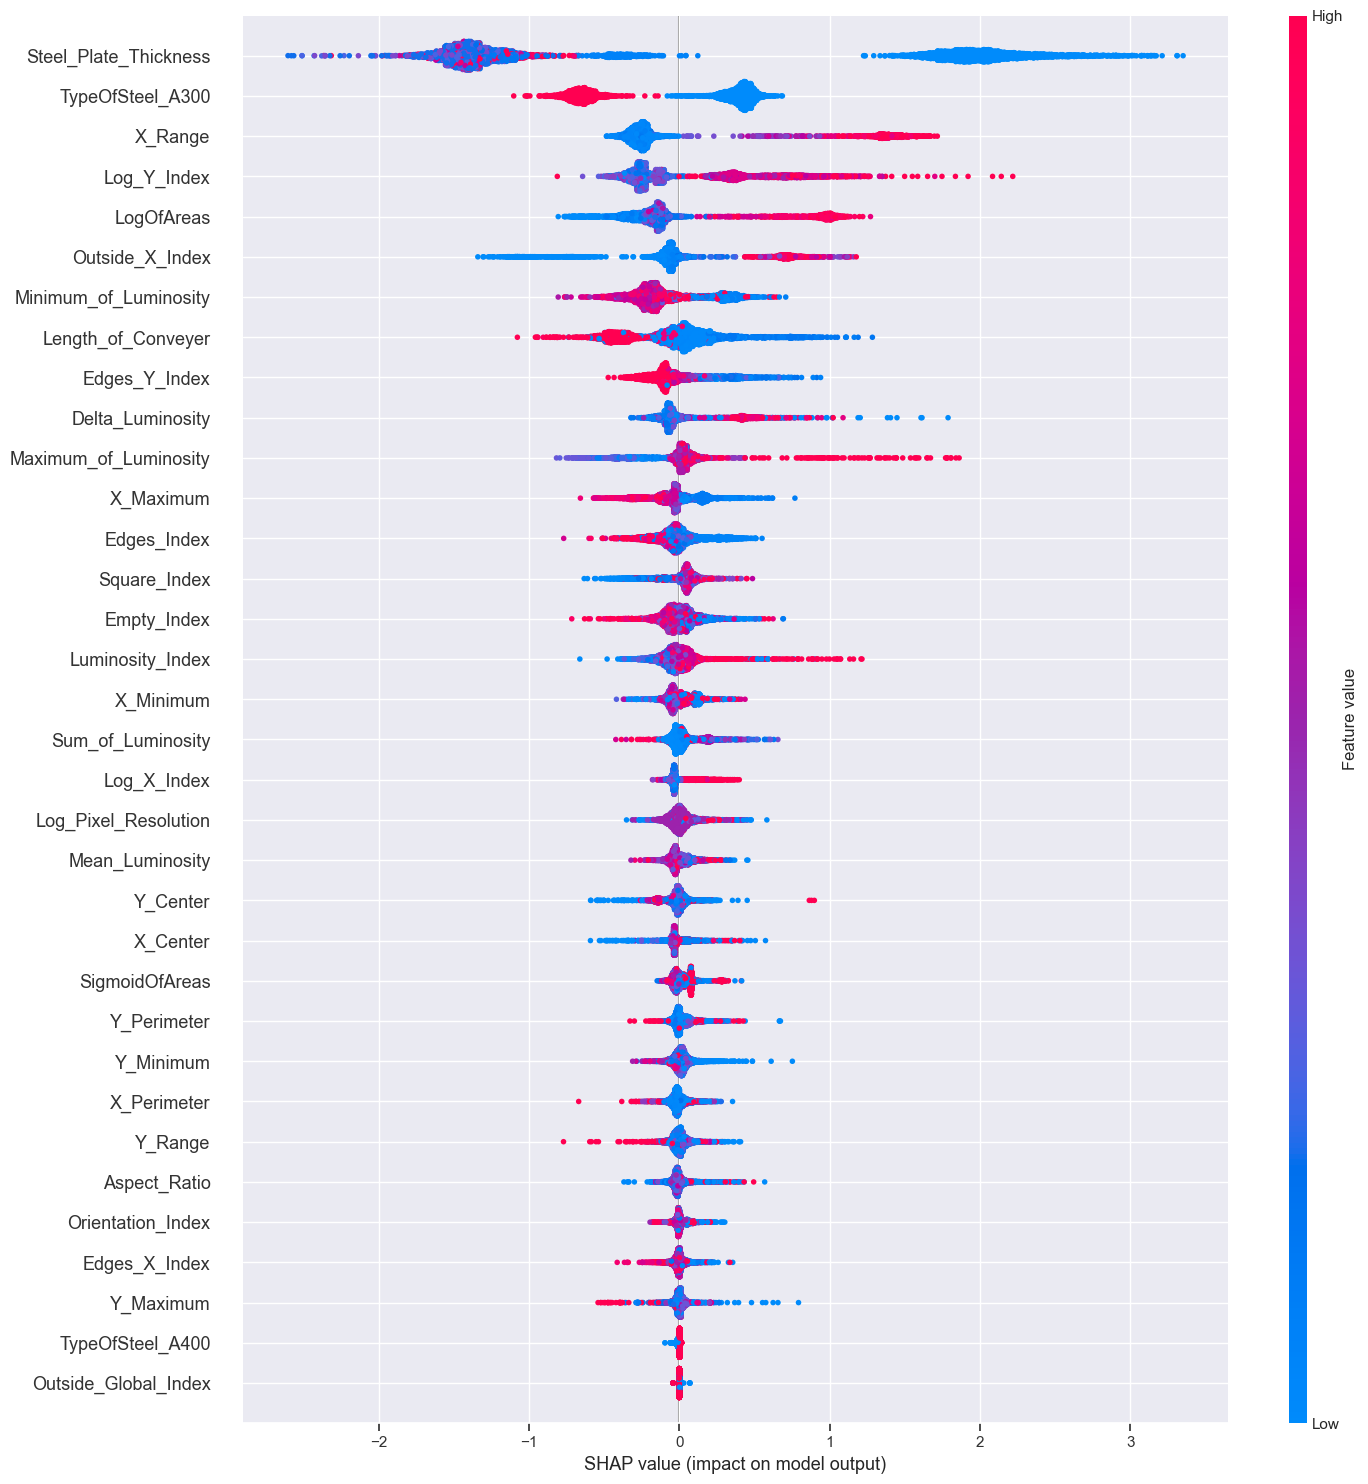

Stains


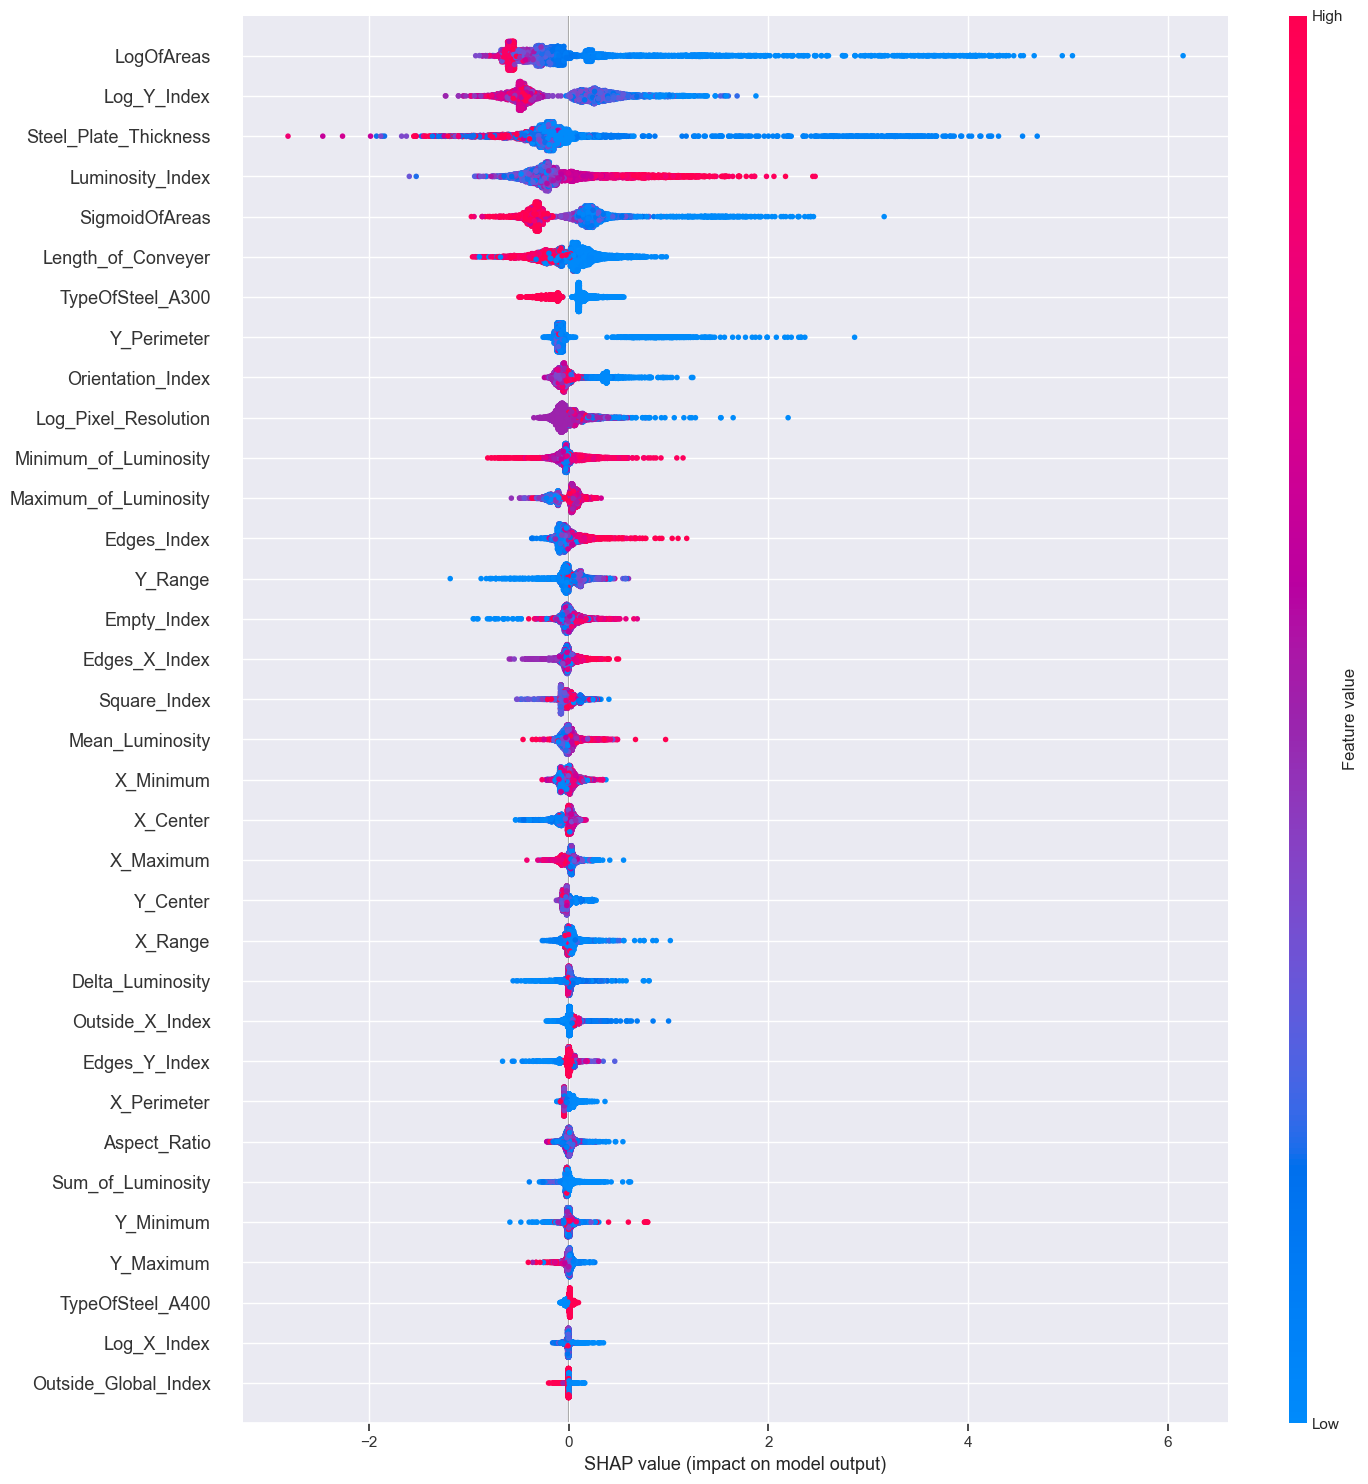

Dirtiness


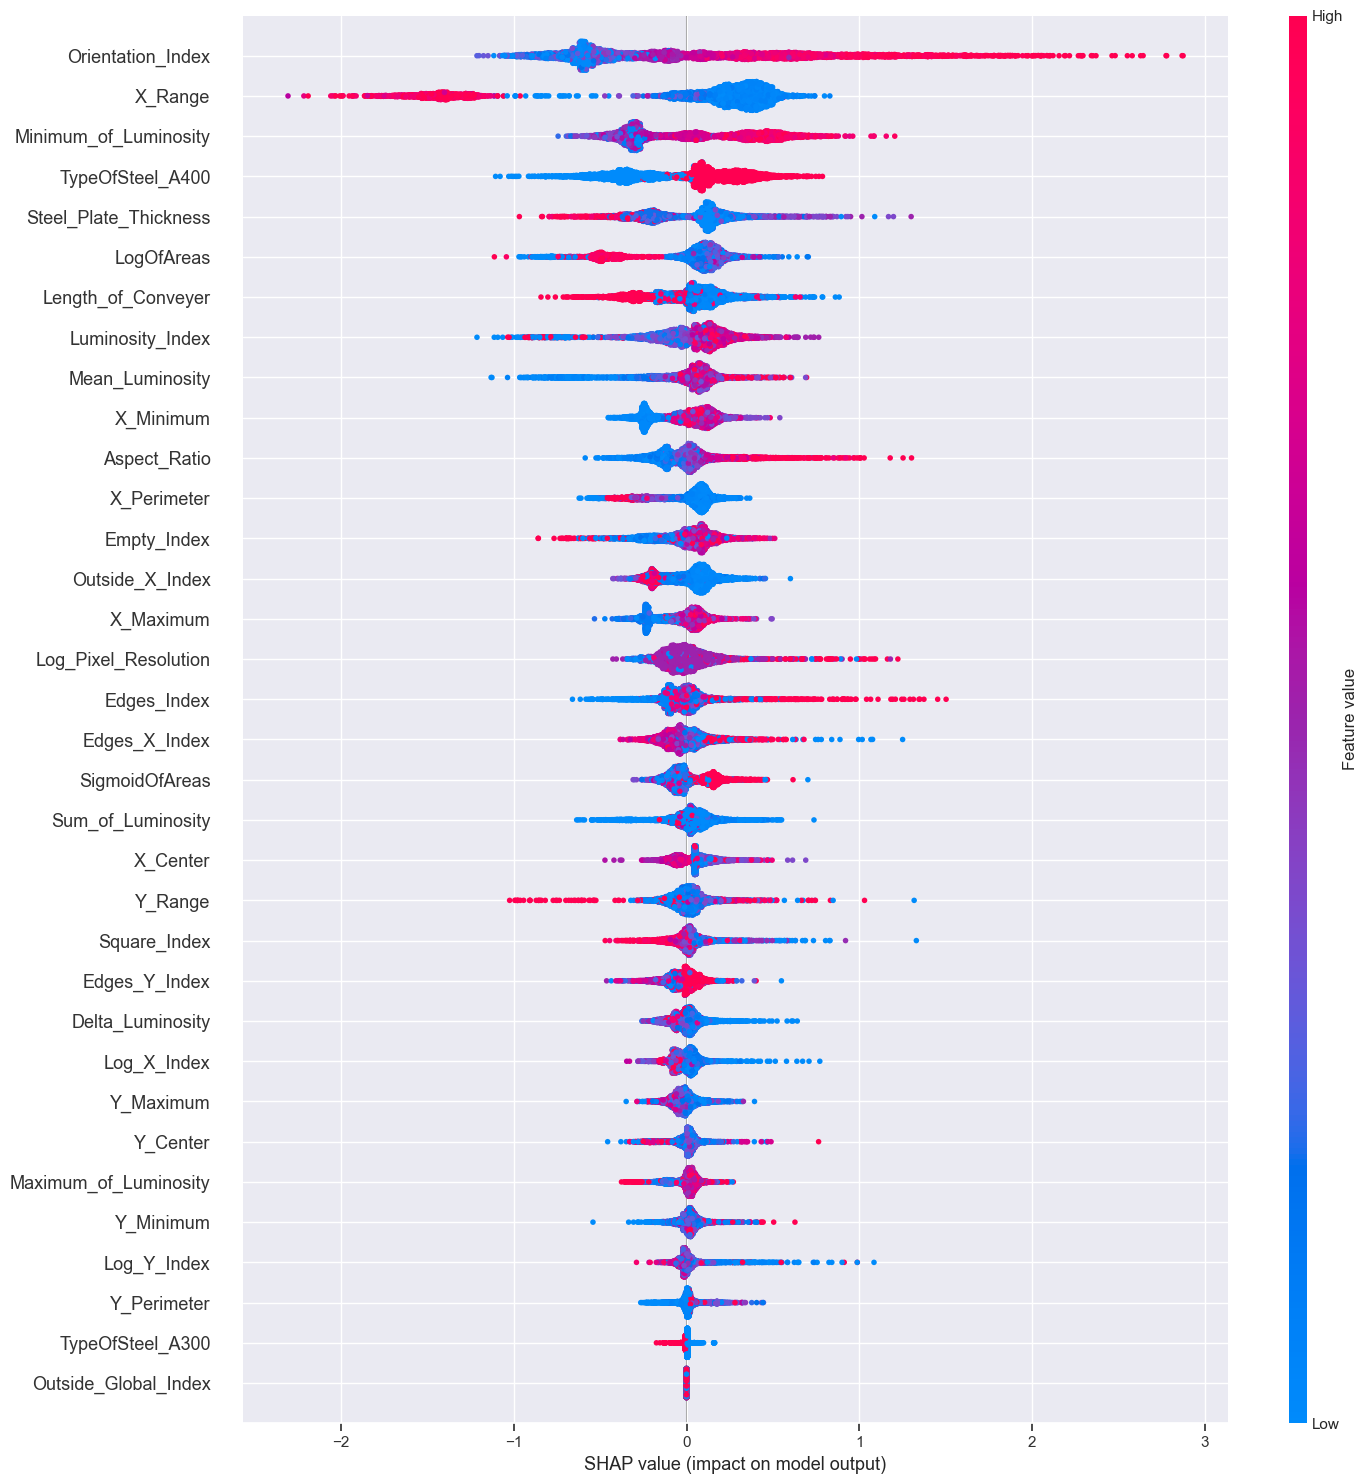

Bumps


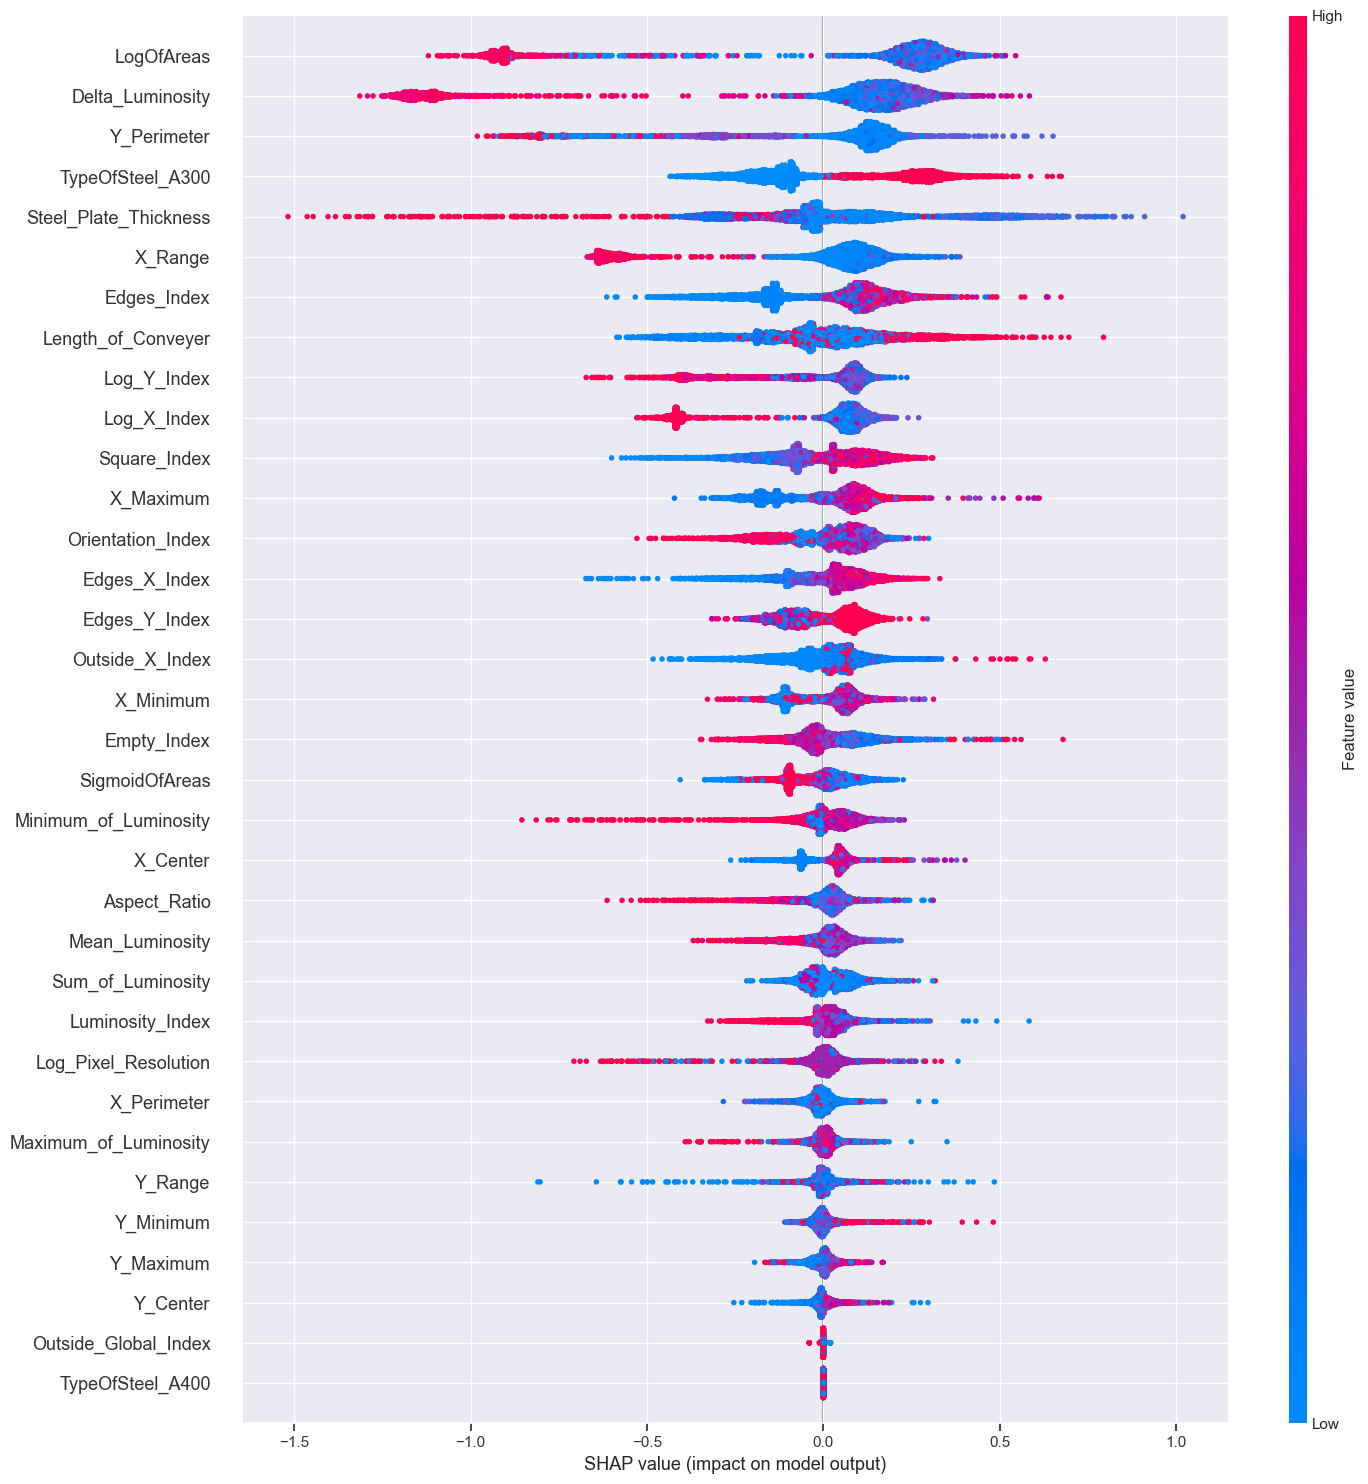

Other_Faults


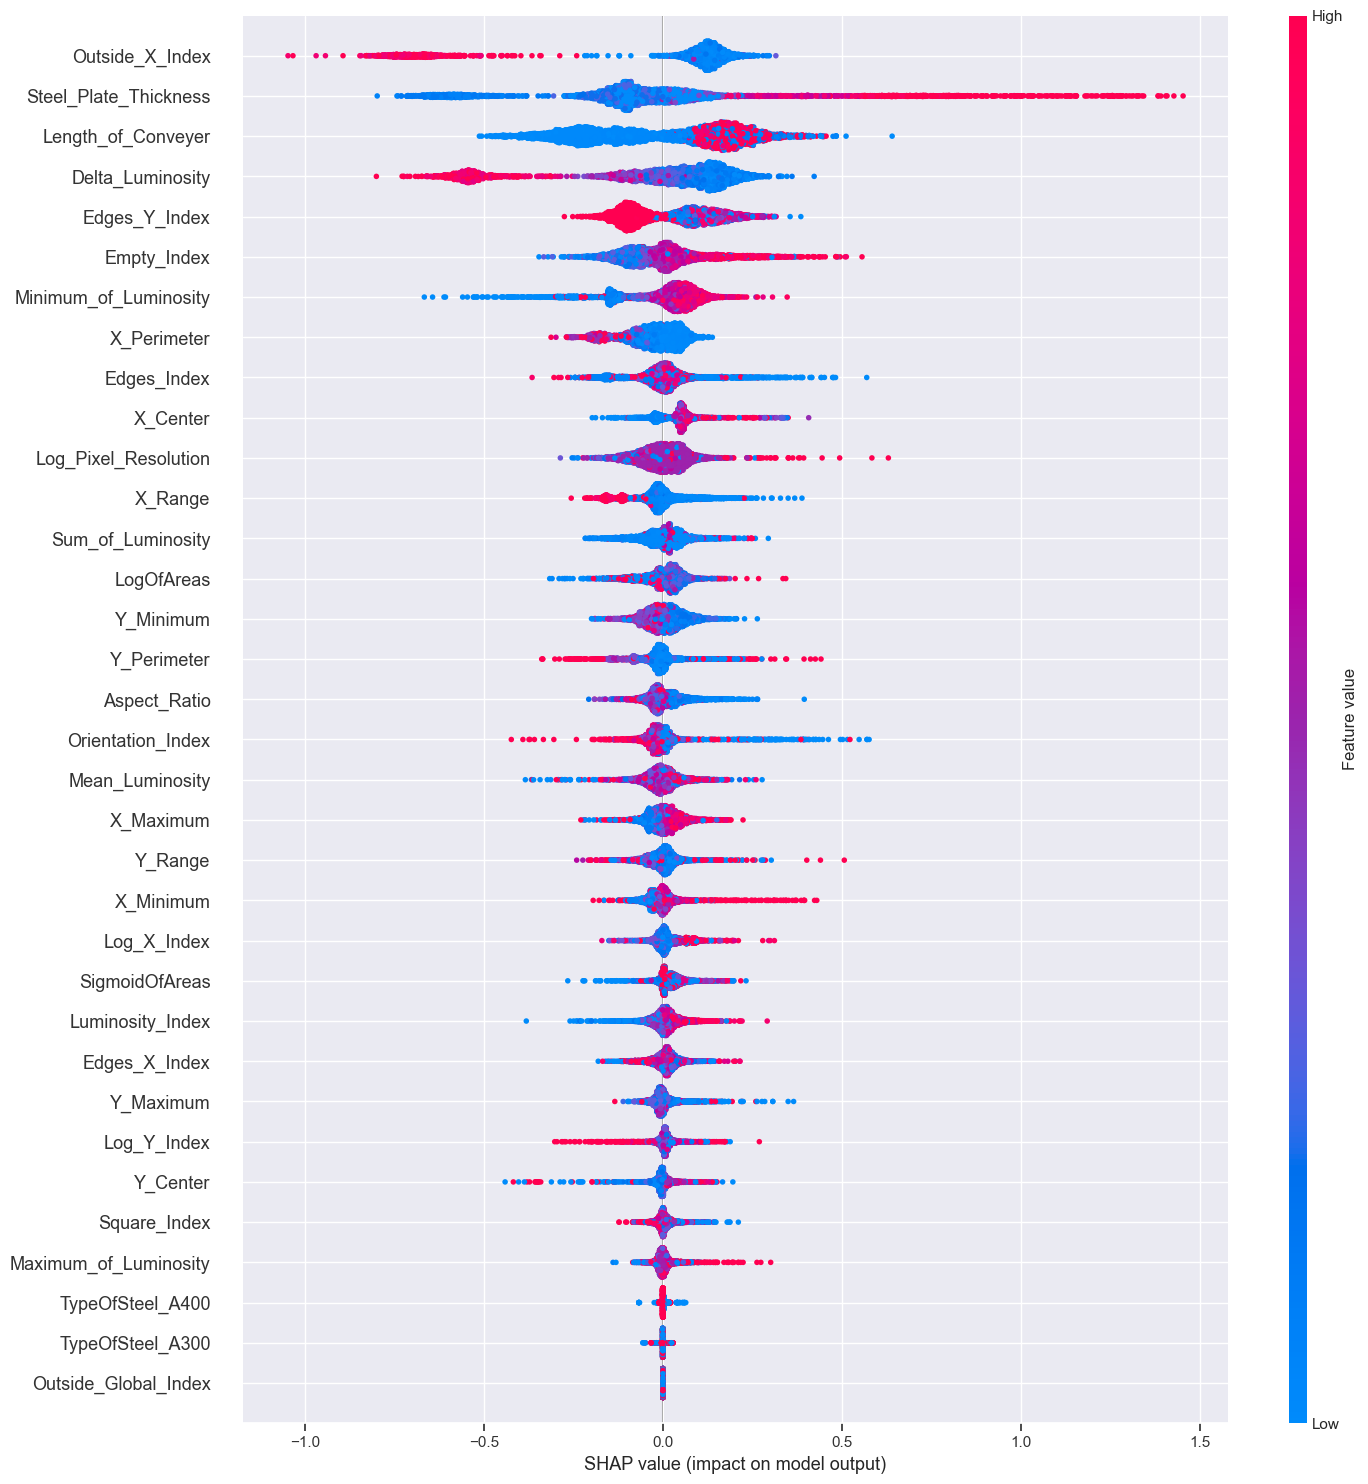

In [76]:
for defect in predict_features:
    model = models['LGBM'][defect]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    print(defect)
    shap.summary_plot(shap_values[1], X_val, max_display=40, plot_size=(15, 15))

**Prepare submission files**
- One submission each model.
- One submission of mixed models, based on best score on respective defect type.

In [82]:
X_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
Y_full = pd.concat([Y_train, Y_val], axis=0).reset_index(drop=True)

for model_type in models:
    df_submit = df_test_raw[['id']]
    for feature in predict_features:
        model = models[model_type][feature]
        model.fit(X_full, Y_full[feature])
        df_submit[feature] = model.predict_proba(X_test)[:, 1]
    df_submit.to_csv(output_path + model_type + ' default submit.csv',
                     index=False)

df_submit = df_test_raw[['id']]
for feature in predict_features:
    model_type = df_auc.sort_values(feature, ascending=False)['Model'].to_list()[0] # model with best score
    model = models[model_type][feature]
    model.fit(X_full, Y_full[feature])
    df_submit[feature] = model.predict_proba(X_test)[:, 1]
df_submit.to_csv(output_path + 'Mix default submit.csv', index=False)